In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.linalg import expm

from Code.Drawing import line
from Code.Visualization import plot_grid2d, plot_grid3d
from Code.util import *

from scipy.stats import ttest_ind, norm

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False
MM = 1/25.4

# Background Analysis

## The distribution of the step sizes

In [2]:
l = 7
step_sizes = np.zeros(l**3)
s = np.linspace(-0.08, 0.08, num=l)
for i, j, k in product(range(l), repeat=3):
    step_sizes[i * l**2 + j * l + k] = s[i]**2 + s[j]**2 + s[k]**2
step_sizes = np.round(np.sqrt(step_sizes), 8)

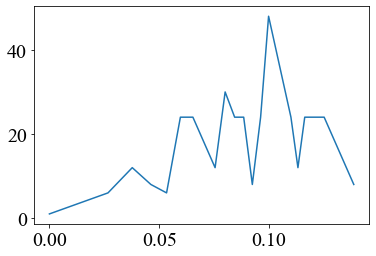

In [3]:
unique_step_sizes, step_size_counts = np.unique(step_sizes, return_counts=True)
plt.plot(unique_step_sizes, step_size_counts)

## The rotation theorem holds for small $r$ and $b$

In [2]:
I = np.identity(4, dtype=np.complex128)
U = np.array([[1, 1, 1, 1], 
              [1, np.exp(-2j*np.pi/3), np.exp( 1j*np.pi/3), -1], 
              [1, np.exp( 1j*np.pi/3), np.exp(-2j*np.pi/3), -1],
              [1, -1, -1, 1]]) / 2

assert (U @ np.conj(U.T) - I < 1e-10).all() # Orthogonal

In [3]:
B = init_B(1)

In [4]:
u = np.random.rand(3)
u /= np.linalg.norm(u)
Mu = get_Mu(u)
a = np.pi * 2 * np.random.rand()
Wr = U @ np.diag(1j * B @ Mu @ [np.cos(a), np.sin(a)]) @ np.conj(U)
assert (Wr.T + np.conj(Wr) < 1e-10).all() # Skew-symmetric
Wb = U @ np.diag(1j * B @ u) @ np.conj(U)
assert (Wb.T + np.conj(Wb) < 1e-10).all() # Skew-symmetric

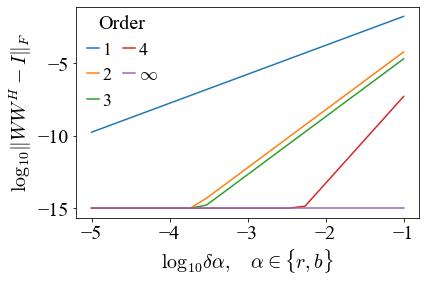

In [5]:
I = np.identity(4, dtype=np.complex128)
log10s = np.linspace(-1, -5, num=20)
eps = -15 # np.log10(np.finfo(np.float64).eps)
n = 4
ds = np.zeros((n+1, 20))
for i in range(n+1):
    for j, s in enumerate(log10s):
        if i < n:
            W, Ws = I.copy(), (Wr + Wb) * 10**s
            for k in range(1, i+2):
                W += Ws / np.math.factorial(k)
                Ws = Ws @ (Wr + Wb) * 10**s
        else:
            W = expm((Wr + Wb) * 10**s)
        ds[i, j] = np.log10(np.linalg.norm(W @ np.conj(W.T) - I, ord='fro'))
    ds[i, ds[i] < eps] = eps
    plt.plot(log10s, ds[i], label=i+1 if i < n else r'$\infty$')

plt.xlabel(r'$\log_{10} \delta \alpha,\hspace{1} \alpha \in \{r, b\}$')
plt.ylabel(r'$\log_{10} \|WW^H - I\|_F$')
plt.legend(title='Order', loc=(0.01, 0.48), fontsize=18, ncol=2, columnspacing=0.6, 
           handlelength=0.7, handletextpad=0.2, frameon=False)
plt.tight_layout(pad=0.5)
plt.savefig('figures/rot_theorem.pdf', transparent=True, dpi=300)

# Simulation Result Analysis

## Planar navigation and 3D circular motion (A1 & B1)

In [665]:
B = init_B(12)

In [666]:
llb, lub = -1, 1
l = []
l.append(line([llb, llb], [llb, lub], num=50))
l.append(line([llb, lub], [lub, lub], num=50))
l.append(line([lub, lub], [lub, llb], num=50))
l.append(line([lub, llb], [llb, llb], num=50))

T = 10000
c = llb + (lub - llb) / 2
x, v, hd = trajectory(np.pi/6, 0.08, T, l, [c, c])
# plt.scatter(x[:, 0], x[:, 1], s=5)

### Planar navigation

In [63]:
x = np.load('data/x/05102337.npy')[:5000]
x[:, 2] = 0 # 2d
x.shape

(5000, 3)

In [64]:
u, r, phi, b = calc_u(x, u_init=np.array([0, 0, 1]), change_int=len(x))

In [65]:
a = sim(u, r, phi, b, change_int=len(x), B_scale=10) 

In [66]:
spikes = np.random.poisson(lam=1/(1 + np.exp(-(a - 0.6) * 30)), size=(len(a), 4))

In [667]:
u = [0, 0, 1]
Mu = get_Mu(u)
dr = np.linalg.norm(v, axis=-1)
db = 0 * np.random.rand()

In [696]:
a = np.zeros((T, 4), dtype=np.complex)
a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

I = np.identity(4)

for t in range(1, T):
    Wr = U @ np.diag(1j * B @ Mu @ [np.cos(hd[t-1]), np.sin(hd[t-1])]) @ np.conj(U)
    Wb = U @ np.diag(1j * B @ u) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wr * dr[t-1] + Wb * db)
    a[t] = W @ a[t-1]
aang = activity(a) # np.angle(a)

spikes = np.random.poisson(lam=1/(1.1+np.exp(-(aang-0.7)*15)), size=(T, 4))
spikes[spikes > 1] = 1

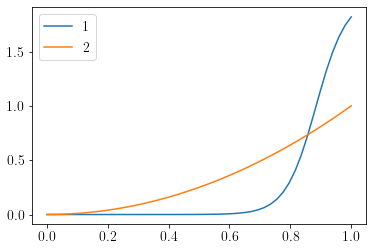

In [697]:
_x = np.linspace(0, 1)
plt.plot(_x, 1/(0.5+np.exp(-(_x-0.85)*20)), label=1)
plt.plot(_x, _x**2, label=2)
plt.legend()

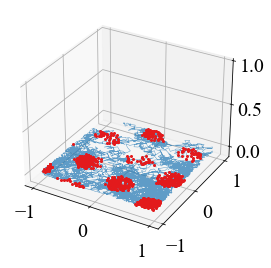

In [87]:
fig, ax = plot_grid3d(x, spikes, '3d', n=5)
ax[0].plot(*x.T, zorder=1, linewidth=0.5, alpha=0.7)
ax[0].set_zlim([-0.1, 1])

fig.set_size_inches(85*MM, 85*MM)
fig.tight_layout(pad=0.1)
fig.savefig('figures/example_2d.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

### 3D circular motion (cell activities along the motion plane)

In [70]:
u = np.random.rand(3)
u /= np.linalg.norm(u)
Mu = get_Mu(u)
dr = np.linalg.norm(v, axis=-1)
db = 0 * np.random.rand()

In [71]:
a = np.zeros((T, 4), dtype=np.complex)
a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

I = np.identity(4)

for t in range(1, T):
    Wr = U @ np.diag(1j * B @ Mu @ [np.cos(hd[t-1]), np.sin(hd[t-1])]) @ np.conj(U)
    Wb = U @ np.diag(1j * B @ u) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wr * dr[t-1] + Wb * db)
    a[t] = W @ a[t-1]
aang = activity(a) # np.angle(a)

spikes = np.random.poisson(lam=1/(1.1+np.exp(-(aang-0.7)*15)), size=(T, 4))
spikes[spikes > 1] = 1

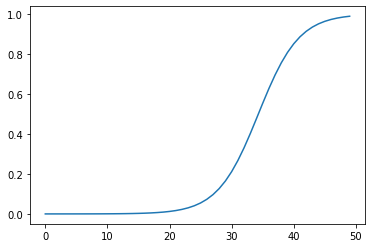

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(1/(1+np.exp(-(np.linspace(0, 1)-0.7)*15)))

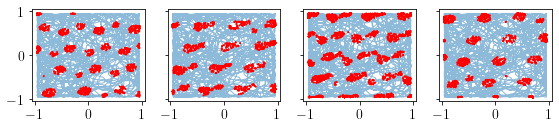

In [72]:
plot_grid2d(x, spikes, th=1, r=4)

## Pure spatial translation (A3 & B3)

In [88]:
B = init_B(10, rotz=8)

In [89]:
T = 100000
x = np.load('data/x/05102337.npy')
u, r, phi, b = calc_u(x, change_int=T, linear=True, kappa=500)

In [90]:
a = sim(u, r, phi, b, change_int=T, uncert=False)

In [117]:
a = np.zeros((T, 4), dtype='complex')
a[0] = np.exp(2j * np.pi * np.array([0, 0, 0, 3/4]))

I = np.identity(4)

for t in range(1, T):
    u_ = x[t] - x[t-1]
    b_ = np.linalg.norm(u_)
    if b_ == 0:
        a[t] = a[t-1]
        continue
    Wb = U @ np.diag(1j * B @ (u_ / b_)) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wb * b_)
    a[t] = W @ a[t-1]
a = activity(a) # np.angle(a)

In [118]:
# x = np.load('data/x/05102337.npy')[:20000]
# # aang = np.load('data/a_c/c_05102337_100000.npy')
# T = len(x)

In [91]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(a-0.75)*30)), size=(len(x), 4))
spikes[spikes > 1] = 1

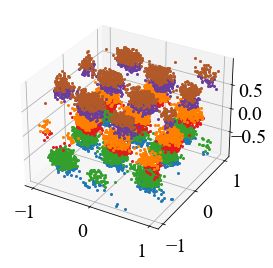

In [92]:
fig, ax = plot_grid3d(x, spikes, '3d', n=6)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_zticklabels([])
fig.set_size_inches(85*MM, 85*MM)
fig.tight_layout(pad=0.1)
fig.savefig('figures/example_perfect3d_1.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

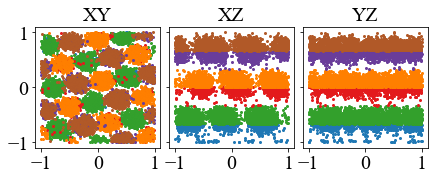

In [96]:
fig, ax = plot_grid3d(x, spikes, '2d', n=6)
ax[0, 0].set_title('XY', fontsize=20)
ax[0, 1].set_title('XZ', fontsize=20)
ax[0, 2].set_title('YZ', fontsize=20)
# for i in range(3):
#     ax[0, i].set_xticklabels([])
#     ax[0, i].set_yticklabels([])
fig.set_size_inches(150*MM, 60*MM)
fig.tight_layout(pad=0.1)
fig.savefig('figures/example_perfect3d_2.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

In [360]:
rd_ttest = dict() # t-score at 0, p value at 1
for i in range(3):
    for j in range(i+1, 3):
        rd_ttest[(i, j)] = tuple(ttest_ind(rd[:, i], rd[:, j]))
rd_ttest

{(0, 1): (0.3918746816197098, 0.69554077145542),
 (0, 2): (4.970778795073179, 1.3651034494362541e-06),
 (1, 2): (4.5645180627722235, 8.438171020913234e-06)}

In [218]:
from scipy.stats import ttest_1samp
ttest_1samp(rd[:, 2], 1)

Ttest_1sampResult(statistic=1.1004479213479148, pvalue=0.27553248272234904)

## Helical motion and spatial translation with a reference to a supportive plane (A2 & B2)

In [2]:
B = init_B(8)

### Static plane

In [ ]:
T = 40000
change_int = 40000
u_init = np.array([0, 0, 1])
x, u, r, phi, b = trajectory3d(np.ones(3) * 0.08, np.ones(3) * 0.1, T, np.zeros(3), u_init, change_int)

In [655]:
a = np.zeros((T, 4), dtype=np.complex)
a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

I = np.identity(4)

for t in range(1, T):
    Mu = get_Mu(u[t-1])
    Wr = U @ np.diag(1j * B @ Mu @ [np.cos(phi[t-1]), np.sin(phi[t-1])]) @ np.conj(U)
    Wb = U @ np.diag(1j * B @ u[t-1]) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wr * r[t-1] + Wb * b[t-1])
#     W = expm(Wb * b[t-1])
#     W = expm(Wr * r[t-1])
    a[t] = W @ a[t-1]
aang = activity(a)

In [656]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(aang-0.85)*30)), size=(T, 4))
spikes[spikes > 1] = 1

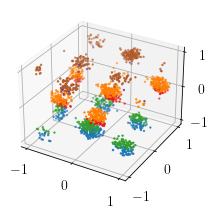

In [657]:
plot_grid3d(x, spikes, '3d', n=6)

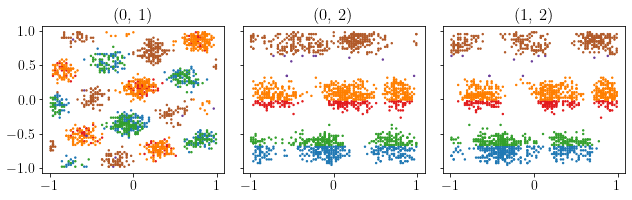

In [658]:
plot_grid3d(x, spikes, '2d', n=6)

### Changing plane

In [611]:
T = 40000
change_int = 1000
x, u, r, phi, b = trajectory3d(np.ones(3) * 0.08, np.ones(3) * 0.1, T, np.zeros(3), np.random.rand(3), change_int)

In [612]:
a = np.zeros((T, 4), dtype=np.complex)
a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

I = np.identity(4)

for t in range(1, T):
    Mu = get_Mu(u[t-1])
    Wr = U @ np.diag(1j * B @ Mu @ [np.cos(phi[t-1]), np.sin(phi[t-1])]) @ np.conj(U)
    Wb = U @ np.diag(1j * B @ u[t-1]) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wr * r[t-1] + Wb * b[t-1])
#     W = expm(Wb * b[t-1])
#     W = expm(Wr * r[t-1])
    a[t] = W @ a[t-1]
aang = activity(a) # np.angle(a)

In [613]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(aang-0.85)*30)), size=(T, 4))
spikes[spikes > 1] = 1

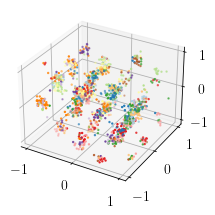

In [614]:
plot_grid3d(x, spikes, '3d', T=change_int)

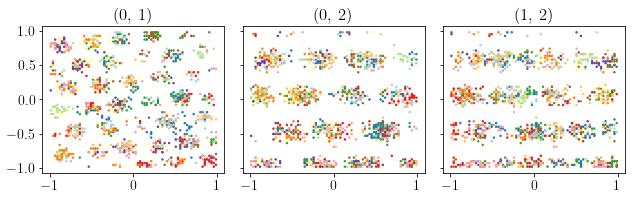

In [615]:
plot_grid3d(x, spikes, '2d', T=change_int)

### Changing plane with uncertainty

In [49]:
B = init_B(10, rotz=8)

In [637]:
T = 40000
change_int = 1000
x, u, r, phi, b = trajectory3d(np.ones(3) * 0.08, np.ones(3) * 0.1, T, np.zeros(3), np.random.rand(3), change_int)

In [638]:
a = np.zeros((T, 4), dtype=np.complex)
a[0] = np.exp(2j * np.pi * np.array([0, 1/2, 1, 3/4]))

I = np.identity(4)

kappa = 600
u_ = np.squeeze(vonmisesfisher3d.x[vonmisesfisher3d.rvs(u[0], kappa)])
for t in range(1, T):
    if t % change_int == 0: # u changes here
        u_ = np.squeeze(vonmisesfisher3d.x[vonmisesfisher3d.rvs(u[t-1], kappa)])
#     u_ = u_ * 0.9 + u[t-1] * 0.1
    Mu = get_Mu(u_)
    Wr = U @ np.diag(1j * B @ Mu @ [np.cos(phi[t-1]), np.sin(phi[t-1])]) @ np.conj(U)
    Wb = U @ np.diag(1j * B @ u_) @ np.conj(U)
#     W = I + Wr * dr[t-1] + Wr @ Wr * dr[t-1]**2/2 + Wb * db + Wb @ Wb * db**2/2
    W = expm(Wr * r[t-1] + Wb * b[t-1])
#     W = expm(Wb * b[t-1])
#     W = expm(Wr * r[t-1])
    a[t] = W @ a[t-1]
aang = activity(a) # np.angle(a)

In [97]:
x = np.load('data/x/05102337.npy')
aang = np.load('data/a_600/u_05102337_5000.npy')
T = len(x)
change_int=5000

In [98]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(aang-0.85)*30)), size=(T, 4))
spikes[spikes > 1] = 1

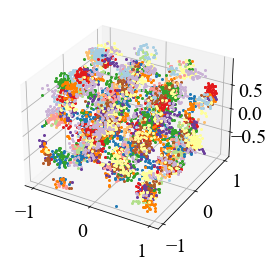

In [99]:
fig, ax = plot_grid3d(x, aang, '3d', T=change_int)
fig.set_size_inches(85*MM, 85*MM)
fig.tight_layout(pad=0.1)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_zticklabels([])
fig.savefig('figures/example_uncert3d.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

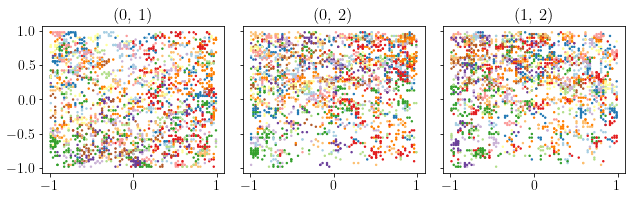

In [641]:
plot_grid3d(x, aang, '2d', T=change_int)

## Manifold

In [100]:
x = np.load('data/x/05102337.npy')[:10000]

sig = 0.2
locs = np.array([[0.6, 0.6], [-0.6, 0.6], [-0.6, -0.6], [0.6, -0.6]])

u = np.zeros((len(x), 3))
u[:, 2] = 1

x[:, 2] = 0 # 2d
for loc in locs:
    z = (x[:, :2] - loc[None, :]) / sig
    gauss = np.exp(-(z**2).sum(axis=1)/2)
    
    x[:, 2] += gauss 
    u[:, 0] += gauss * z[:, 0] / sig # Negative signs cancel
    u[:, 1] += gauss * z[:, 1] / sig

In [101]:
change_int = 10
for i in range(0, len(u), change_int):
    u[i:i+change_int] = u[i]

In [102]:
u, r, phi, b = calc_u(x, u_=u, change_int=change_int)

In [103]:
a = sim(u, r, phi, b * 0, change_int=change_int)

In [104]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(a-0.85)*30)), size=(len(x), 4))
spikes[spikes > 1] = 1

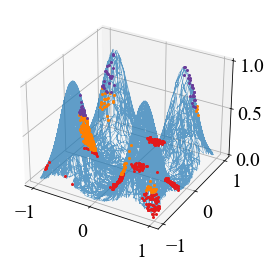

In [105]:
fig, ax = plot_grid3d(x, spikes, '3d', n=5)
# ax[0].get_lines()[0].set_color('r')
ax[0].plot(*x.T, zorder=1, linewidth=0.5, alpha=0.7)
ax[0].set_zlim([0, 1])
fig.set_size_inches(85*MM, 85*MM)
fig.tight_layout(pad=0.1)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_zticklabels([])
fig.savefig('figures/example_manifold1.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

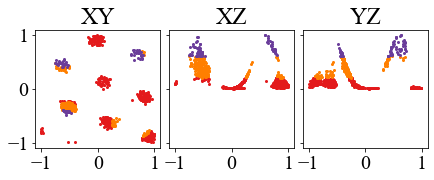

In [106]:
fig, ax = plot_grid3d(x, spikes, '2d', n=5)
ax[0, 0].set_title('XY')
ax[0, 1].set_title('XZ')
ax[0, 2].set_title('YZ')
# for i in range(3):
#     ax[0, i].set_xticklabels([])
#     ax[0, i].set_yticklabels([])
fig.set_size_inches(150*MM, 60*MM)
fig.tight_layout(pad=0.1)
fig.savefig('figures/example_manifold2.pdf', transparent=True, dpi=300, pad_inches=0, bbox_inches='tight')

In [10]:
a = sim(u, r, phi, b, change_int=change_int)

In [11]:
spikes = np.random.poisson(lam=1/(0.6+np.exp(-(a-0.85)*30)), size=(len(x), 4))
spikes[spikes > 1] = 1

[Text(0.0, 0, ''),
 Text(0.25, 0, ''),
 Text(0.5, 0, ''),
 Text(0.75, 0, ''),
 Text(1.0, 0, '')]

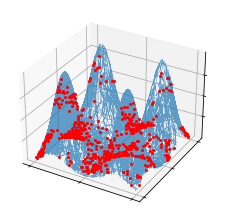

In [12]:
fig, ax = plot_grid3d(x, spikes, '3d')
ax[0].get_lines()[0].set_color('r')
ax[0].plot(*x.T, zorder=1, linewidth=0.5, alpha=0.7)
fig.tight_layout(pad=0.2)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_zticklabels([])
# fig.savefig('figures/example_uncert3d.png', transparent=True, dpi=300)

(<Figure size 576x216 with 3 Axes>,
 array([[<AxesSubplot:title={'center':'(0, 1)'}>,
         <AxesSubplot:title={'center':'(0, 2)'}>,
         <AxesSubplot:title={'center':'(1, 2)'}>]], dtype=object))

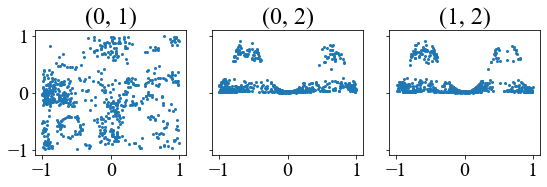

In [13]:
plot_grid3d(x, spikes, '2d')